<a id="top"></a>
# Correcting for Scattered Light in WFC3/IR Exposures: Using `calwf3` to Mask Bad Reads


## Learning Goals

This notebook shows one of two available methods to correct for time-variable background 
(TVB) due to scattered light from observing close to the Earth's limb. This method illustrates how to mask bad reads in the RAW image and then reprocess with `calwf3`, and it may be used for rejecting anomalous reads occurring either at the beginning or at the end of an exposure.


By the end of this tutorial, you will: 

- Compute and plot the difference between IMA reads to identify the reads affected by TVB.
- Reprocess a single exposure with `calwf3` by excluding the first few reads which are affected by scattered light.
- Compare the original FLT to the reprocessed FLT image.
- Compare the original DRZ to the reprocessed DRZ image.

A second method (manually subtracting bad reads from the final IMA read) can 
be found in the notebook [Correcting for Scattered Light in WFC3/IR Exposures: Manually Subtracting Bad Reads (O'Connor 2023)](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/ir_scattered_light_manual_corrections). This provides a method for removing anomalies such as satellite trails which appear in the middle of an IMA exposure.  One caveat of the second method is that it does not perform the 'ramp fitting' step and therefore the calibrated FLT products will still contain cosmic rays.  

<div class="alert alert-block alert-info">

**Please note that this method may leave large sky residuals in regions 
corresponding to WFC3/IR 'blobs', flagged in the FLT data quality (DQ) array as a value of 512. This method is therefore recommended for observations acquired using an WFC3-IR-DITHER-BLOB dither (or POSTARG equivalent) to step over blob regions. Software such
as AstroDrizzle may then be used to combine the FLT exposures, while excluding pixels 
with 512 flags (or any bit-wise combination of 512 and another flag e.g. 576 = 512 + 64).**

</div>

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Downloading Data](#load) <br>
[3. Identifying Reads with Time Variable Background](#identify) <br>
[4. Querying CRDS for the Reference File](#ref) <br>
[5. Reprocessing the Observation](#main) <br>
- [5.1 Re-running `calwf3`](#reprocess) <br>
- [5.2 Comparing FLT Products](#compare) <br>

[6. Drizzling Nominal and Reprocessed FLT Products](#drizzle) <br>
[7. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>


## Introduction <a id="intro"></a>

Observations with strong time variability in the sky background during a MULTIACCUM ramp can corrupt the WFC3 `calwf3` 'linear ramp fit' and cosmic-ray identification algorithm (CRCORR, [Section 3.3.10 of the Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-3-wfc3-data-calibration/3-3-ir-data-calibration-steps#id-3.3IRDataCalibrationSteps-3.3.10)). The CRCORR 
algorithm assumes that a given pixel sees a constant count rate throughout the read from a 
combination of sources and diffuse background (i.e., the integrated signal "ramps" are linear). A background 
varying strongly with time (i.e. where the "ramps" are non-linear) can trigger the cosmic-ray 
(CR) flagging thresholds in `calwf3`, causing the algorithm to identify most or all of the pixels as a CR at any given read.

In this notebook we will examine an observation affected by strong TVB, 
specifically due to Earth limb scattered light ([Section 7.10 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background)) affecting the first few reads and producing a spatially variable background. We will run `calwf3` while rejecting the affected reads to create an improved FLT product with a flat background and an improved ramp fit. One caveat is that the new FLT will 
have a reduced total exposure time, given the rejection of some number of reads, and 
therefore a lower signal-to-noise ratio.

Please see the notebook  [WFC3/IR IMA Visualization with An Example of Time Variable Background (O'Connor 2023)](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/ir_ima_visualization/IR_IMA_Visualization_with_an_Example_of_Time_Variable_Background.ipynb) for a walkthrough of how to identify a TVB in due to scattered light. 

## 1. Imports <a id="import"></a>

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:

- *os* for setting environment variables
- *glob* for finding lists of files
- *shutil* for managing directories
- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy.io fits* for accessing FITS files
- *astroquery.mast Observations* for downloading data
- *wfc3tools* `calwf3` for calibrating WFC3 data
- *ginga* for finding min/max outlier pixels
- *stwcs* for updating World Coordinate System images
- *drizzlepac* for combining images with AstroDrizzle 

We import the following modules:
- *ima_visualization_and_differencing* to take the difference between reads, plot the ramp, and visualize the difference in images


In [1]:
import os 
import glob
import shutil 
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astroquery.mast import Observations
from wfc3tools import calwf3
from ginga.util.zscale import zscale
from stwcs import updatewcs
from drizzlepac import astrodrizzle

import ima_visualization_and_differencing as diff

%matplotlib inline



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 2. Downloading Data<a id="load"></a>

The following commands query MAST for the necessary data products and download them to the current directory. Here we obtain WFC3/IR observations from HST Frontier Fields program [14037](https://archive.stsci.edu/proposal_search.php?id=14037&mission=hst), Visit BB. We specifically want the observation `icqtbbbxq`, as it is strongly affected by Earth limb scattered light. The data products requested are the RAW, IMA, and FLT files. For an example of TVB at the end of an exposure, we include an alternate dataset (OBS_ID = `ICXT27020`, file_id = `icxt27hkq`) in which the Earth limb affects the reads at the end of the MULTIACCUM sequence (SCI,1 through  SCI,5). 

**Warning: this cell may take a few minutes to complete.**

In [2]:
OBS_ID = 'ICQTBB020' # Earth-limb at the start 
# OBS_ID = 'ICXT27020' # Earth-limb at the end 
data_list = Observations.query_criteria(obs_id=OBS_ID)

file_id = "icqtbbbxq"
# file_id = 'icxt27hkq'
Observations.download_products(data_list['obsid'], project='CALWF3', 
                               obs_id=file_id, mrp_only=False, 
                               productSubGroupDescription=['RAW', 'IMA', 'FLT'])

 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_raw.fits,COMPLETE,None,None


Now, we will move our IMA and FLT files to a separate directory called "orig/" so they are not overwritten when we run `calwf3`. We leave our RAW file in the working directory for later use.

In [3]:
if not os.path.exists('orig/'):
    os.mkdir('orig/')

shutil.copy(f'mastDownload/HST/{file_id}/{file_id}_ima.fits', f'orig/{file_id}_ima.fits')
shutil.copy(f'mastDownload/HST/{file_id}/{file_id}_flt.fits', f'orig/{file_id}_flt.fits')  

raw_file = f'mastDownload/HST/{file_id}/{file_id}_raw.fits'

remove_files_list = glob.glob(f'./{file_id}_*.fits')
for rm_file in remove_files_list:
    os.remove(rm_file)

shutil.copy(raw_file, f'{file_id}_raw.fits')

'icqtbbbxq_raw.fits'

## 3. Identifying Reads with Time Variable Background<a id="identify"></a>

In this section, we show how to identify the reads impacted by TVB by examining the difference in count rate between reads. This section was taken from the [WFC3/IR IMA Visualization with An Example of Time Variable Background (O'Connor 2023)](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/ir_ima_visualization/IR_IMA_Visualization_with_an_Example_of_Time_Variable_Background.ipynb) notebook, which includes a more comprehensive walkthrough of identifying time variable background in WFC3/IR images. 

Here we implement a technique to examine the count rate difference between consecutive reads. In this case, we first convert from count rate (electrons/second) back to counts (electrons) before taking the difference, as shown in equation 3 from [WFC3 ISR 2018-05](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-05.pdf). 

![Instantaneous Difference Equation](instantaneous_diff.png)

We compare sky values in different regions of the detector (left side, right side, and full frame). If you would like to specify your own regions for the left and right sides of your image, you can change the `lhs_region` and `rhs_region` parameters. Each region must be specified as a dictionary including the four "corners" (x0, x1, y0, and y1) of the region you would like to select. You may want to avoid the edges of the detector which have a large number of bad pixels and higher flat field errors.

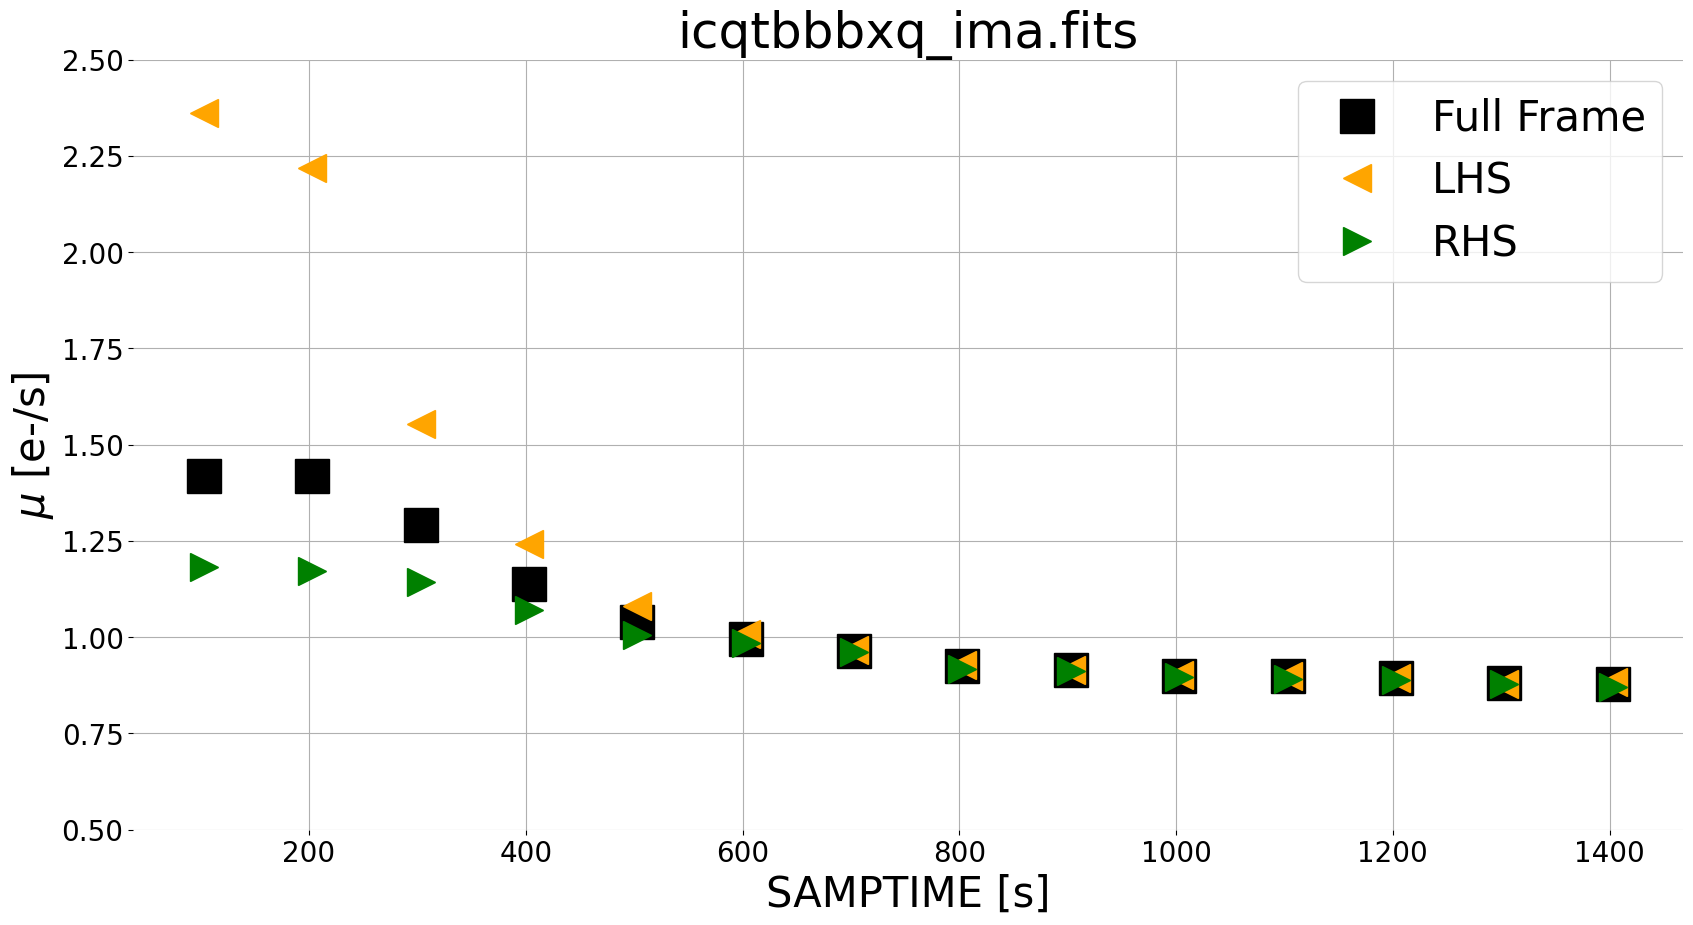

In [4]:
fig = plt.figure(figsize=(20, 10))

ima_filepath = f'orig/{file_id}_ima.fits'

path, filename = os.path.split(ima_filepath)
cube, integ_time = diff.read_wfc3(ima_filepath)

lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}

# Please use a limit that makes sense for your own data, when running your images through this notebook.
cube[np.abs(cube) > 3] = np.nan

diff_cube = diff.compute_diff_imas(cube, integ_time, diff_method="instantaneous")
median_diff_fullframe, median_diff_lhs, median_diff_rhs = (
    diff.get_median_fullframe_lhs_rhs(
        diff_cube, 
        lhs_region=lhs_region, 
        rhs_region=rhs_region))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'lines.markersize': 15})

diff.plot_ramp(ima_filepath, integ_time, median_diff_fullframe, median_diff_lhs, median_diff_rhs)

plt.ylim(0.5, 2.5)
_ = plt.title(filename)

Here, we utilize a few functions from our module `ima_visualization_and_differencing`. We use `read_wfc3` to grab the IMA data from all reads and corresponding integration times. We also implement upper and lower limits on our pixel values to exclude sources when plotting our ramp. We take the instantaneous difference using `compute_diff_imas`, which computes the difference as described in the equation above. Finally, we use `plot_ramp` to plot the median count rate from the left side, right side, and full frame image.

For our scattered light exposure, we see  zodiacal light at a level of ~0.9e-/s in later reads, with the scattered light component affecting the first several reads where the median count rate for the left side (orange triangles) is larger than the right side (green triangles). We can visualize this in 2 dimensions in the panel plot below, using the `plot_ima_difference_subplots`.  

In the panel plot, we see that sources (small galaxies) are visible in the difference images using this new method. Note that this may complicate the analysis of the spatial background (e.g. left versus right) for images with extended targets, such as large galaxies. In this case, users may wish to adjust the regions of the detector used for the ramp plots. We therefore recommend inspecting both the panel plots as well as the ramp fits for diagnosing any issues with the data. 

<Figure size 2000x1000 with 0 Axes>

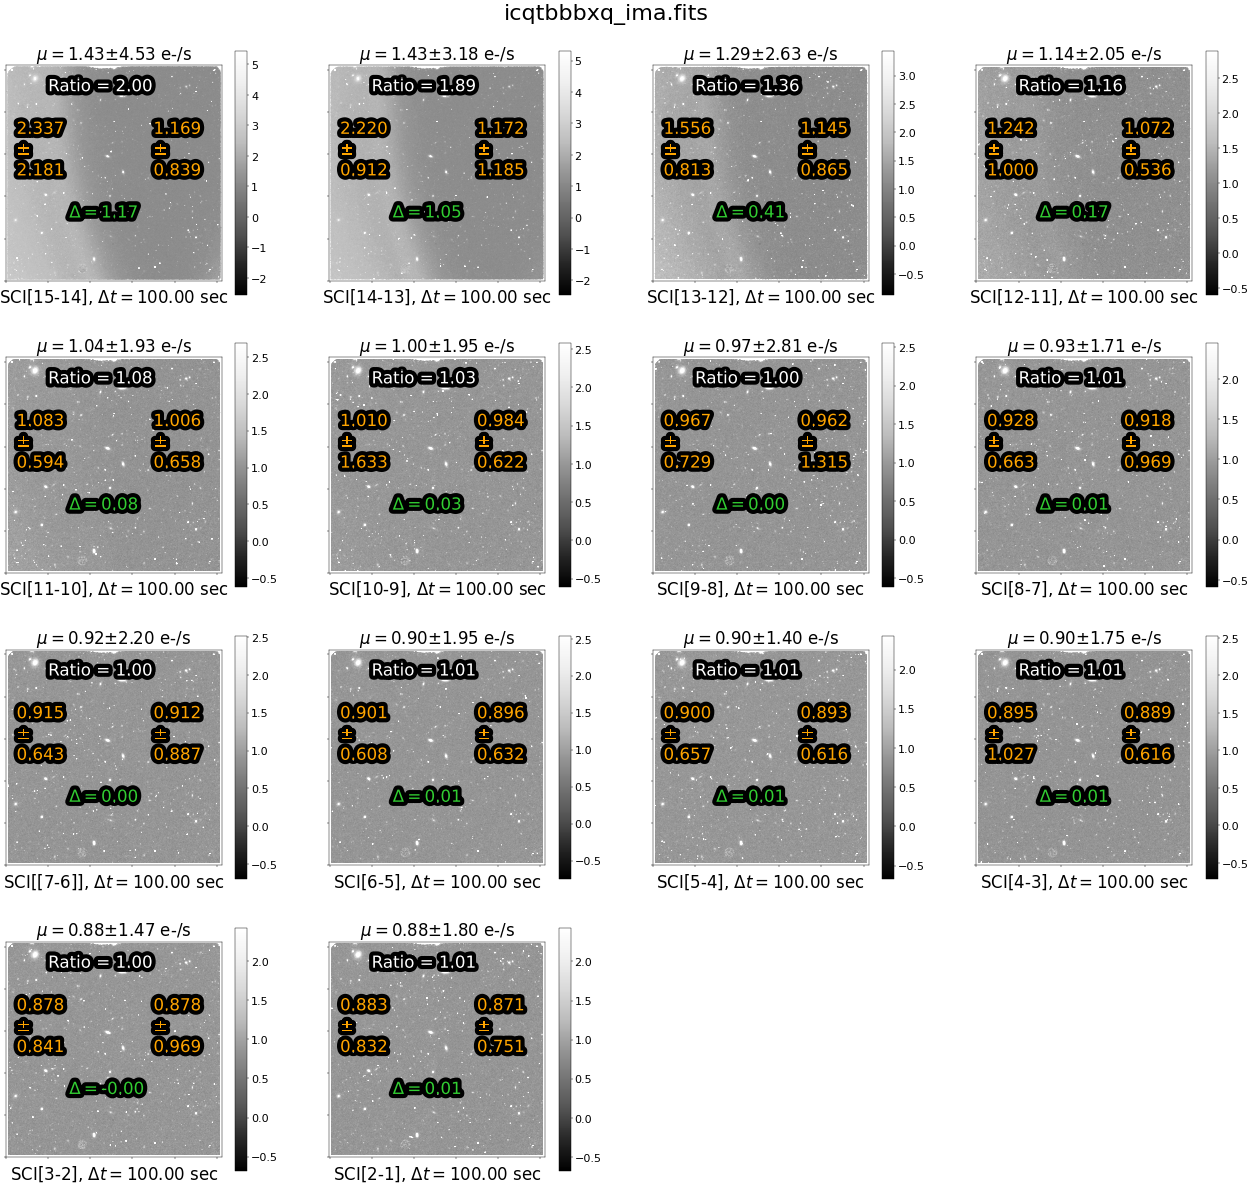

In [5]:
fig = plt.figure(figsize=(20, 10))

ima_filepath = f'orig/{file_id}_ima.fits'

lhs_region = {"x0": 50, "x1": 250, "y0": 100, "y1": 900}
rhs_region = {"x0": 700, "x1": 900, "y0": 100, "y1": 900}

diff.plot_ima_difference_subplots(ima_filepath, 
                                  difference_method='instantaneous', 
                                  lhs_region=lhs_region, 
                                  rhs_region=rhs_region)

In this figure, we see that the ratio of instantaneous rate for the left versus right side of the image is ~1.0 for all but the first few reads (which are affected by scattered light). We choose to exclude reads with a ratio greater than 1.1 from the exposure and reprocess the image with `calwf3`. While this reduces the total exposure from 1403 to 1000 seconds, it removes the spatial component from the sky background and allows for a more accurate 'up-the-ramp' fit with `calwf3`.

## 4. Querying CRDS for the Reference File<a id="ref"></a>

Before running `calwf3`, we need to set some environment variables.

We will point to a subdirectory called `crds_cache` using the IREF environment variable, which is used for WFC3 reference files. Other instruments use other variables, e.g., JREF for ACS.

In [6]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

The code block below will query CRDS for the best reference files currently available for our dataset and update the header keywords to point to these new files. We will use the Python package `os` to run terminal commands. In the terminal, the line would be:

...where 'filename' is the name of your fits file.


**Warning: this cell may take a few minutes to complete.**

In [7]:
raw_file = f'{file_id}_raw.fits'

print(f"Querying CRDS for the reference file associated with {raw_file}.")
command_line_input = 'crds bestrefs --files {:} --sync-references=1 --update-bestrefs'.format(raw_file)
os.system(command_line_input)

Querying CRDS for the reference file associated with icqtbbbxq_raw.fits.


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap       678 bytes  (1 / 142 files) (0 / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap       977 bytes  (2 / 142 files) (678 / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap         642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap       685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap         696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap    30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap       801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_darkfile_0250.rmap   178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_biasfile_0250.rmap     3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_atodfile_0250.rmap       874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_0250.imap                782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_snkcfile_0003.rmap        681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_satufile_0002.rmap      1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pfltfile_0253.rmap     34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pctetab_0004.rmap         698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_oscntab_0250.rmap         747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_npolfile_0254.rmap      4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_nlinfile_0250.rmap        726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_mdriztab_0254.rmap        845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_imphttab_0256.rmap        683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_idctab_0254.rmap          661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_flshfile_0256.rmap      5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_drkcfile_0197.rmap    238.6 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_dfltfile_0002.rmap     17.1 K bytes  (24 / 142 files) (506.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_darkfile_0496.rmap    285.9 K bytes  (25 / 142 files) (523.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_d2imfile_0251.rmap        605 bytes  (26 / 142 files) (809.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_crrejtab_0250.rmap        803 bytes  (27 / 142 files) (810.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_ccdtab_0250.rmap          799 bytes  (28 / 142 files) (810.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_bpixtab_0313.rmap      11.9 K bytes  (29 / 142 files) (811.6 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biasfile_0267.rmap     23.4 K bytes  (30 / 142 files) (823.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biacfile_0003.rmap        692 bytes  (31 / 142 files) (846.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_atodtab_0250.rmap         651 bytes  (32 / 142 files) (847.6 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_0602.imap               1.3 K bytes  (33 / 142 files) (848.2 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmttab_0002.rmap       745 bytes  (34 / 142 files) (849.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmgtab_0012.rmap       767 bytes  (35 / 142 files) (850.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmctab_0055.rmap       743 bytes  (36 / 142 files) (851.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thruput_0059.rmap  329.6 K bytes  (37 / 142 files) (851.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_0070.imap              579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_xtractab_0250.rmap        815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_wcptab_0251.rmap          578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_teltab_0250.rmap          745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdstab_0254.rmap          921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdctab_0252.rmap          650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_srwtab_0250.rmap          745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sptrctab_0251.rmap        895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sdctab_0251.rmap          889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_riptab_0254.rmap          877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_phottab_0258.rmap       1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pfltfile_0250.rmap     23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pctab_0250.rmap         3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mofftab_0250.rmap         747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mlintab_0250.rmap         601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lfltfile_0250.rmap     11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lamptab_0250.rmap         610 bytes  (56 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_inangtab_0250.rmap        815 bytes  (57 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_imphttab_0252.rmap        616 bytes  (58 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_idctab_0251.rmap          775 bytes  (59 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_halotab_0250.rmap         747 bytes  (60 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_gactab_0250.rmap          651 bytes  (61 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_exstab_0250.rmap          745 bytes  (62 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap        749 bytes  (63 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_disptab_0250.rmap         813 bytes  (64 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_darkfile_0357.rmap     60.6 K bytes  (65 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap        711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap          745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap          893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_bpixtab_0250.rmap         845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_biasfile_0359.rmap    120.9 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apertab_0250.rmap         588 bytes  (71 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apdestab_0252.rmap        636 bytes  (72 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_0373.imap               1.7 K bytes  (73 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tdffile_0250.rmap     8.9 K bytes  (76 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_phottab_0250.rmap       862 bytes  (82 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_idctab_0250.rmap        767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_0250.imap             1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_ywlkfile_0003.rmap         922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xwlkfile_0002.rmap         922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xtractab_0269.rmap       1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_wcptab_0257.rmap         1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_twozxtab_0277.rmap         990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tracetab_0276.rmap         998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tdstab_0272.rmap           803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spwcstab_0255.rmap       1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spottab_0006.rmap          766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_proftab_0276.rmap        1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_phatab_0250.rmap           668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_lamptab_0264.rmap        1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvtab_0259.rmap            567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvdstab_0002.rmap        1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_gsagtab_0261.rmap          712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_geofile_0250.rmap          670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_fluxtab_0282.rmap        1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_flatfile_0264.rmap       1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_disptab_0276.rmap        1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_dgeofile_0002.rmap         909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_deadtab_0250.rmap          711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brsttab_0250.rmap          696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brftab_0250.rmap           614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_bpixtab_0260.rmap          773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_badttab_0252.rmap          643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_0359.imap                1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_spottab_0251.rmap          641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_snkcfile_0101.rmap       7.5 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap         531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_satufile_0002.rmap       1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap      69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap          615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap          781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap       3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap          646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap         769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_imphttab_0260.rmap         769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_idctab_0256.rmap         1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_flshfile_0268.rmap       3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_drkcfile_0452.rmap      15.1 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_dgeofile_0250.rmap       3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_darkfile_0443.rmap      87.0 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_d2imfile_0253.rmap         601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_crrejtab_0251.rmap         945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_cfltfile_0250.rmap       1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_ccdtab_0256.rmap         1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_bpixtab_0252.rmap        1.0 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_biasfile_0441.rmap      57.1 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_atodtab_0251.rmap          528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_0542.imap                1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_1197.pmap                      495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing icqtbbbxq_raw.fits


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/35620125i_drk.fits      302.6 M bytes  (1 / 11 files) (0 / 404.7 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/3562014hi_bpx.fits      910.1 K bytes  (2 / 11 files) (302.6 M / 404.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/3562021pi_mdz.fits       40.3 K bytes  (3 / 11 files) (303.5 M / 404.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/4ac18162i_dfl.fits       10.5 M bytes  (4 / 11 files) (303.6 M / 404.7 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/4ac19224i_pfl.fits       10.5 M bytes  (5 / 11 files) (314.1 M / 404.7 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/4af1533ai_imp.fits       40.3 K bytes  (6 / 11 files) (324.6 M / 404.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/q911321mi_osc.fits       20.2 K bytes  (7 / 11 files) (324.7 M / 404.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/t2c16200i_ccd.fits       17.3 K bytes  (8 / 11 files) (324.7 M / 404.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/u1k1727mi_lin.fits       79.9 M bytes  (9 / 11 files) (324.7 M / 404.7 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/u6a1748ri_crr.fits       14.4 K bytes  (10 / 11 files) (404.6 M / 404.7 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/w3m18525i_idc.fits       20.2 K bytes  (11 / 11 files) (404.6 M / 404.7 M bytes)
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  155 infos


0

## 5. Reprocessing the Observation<a id="main"></a>

As discussed in the [introduction](#intro) to this notebook, the accuracy of the ramp fit performed during the CRCORR cosmic-ray rejection step of the pipeline determines the quality of the calibrated WFC3/IR FLT data products. Given that a time variable background can compromise the quality of the ramp fit, observations affected by TVB will likely result in poor-quality calibrated FLT images (see the Appendix of [WFC3 ISR 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)).

To address poorly calibrated FLT images where some reads are affected by scattered light TVB (as in our example observation), we can remove these reads and re-run `calwf3` to produce cleaner FLT images. We choose to exclude reads where the ratio of background signal is greater than 1.1 e-/s (see the notebook [WFC3/IR IMA Visualization with An Example of Time Variable Background (O'Connor 2023)](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/ir_ima_visualization) for a more complete demonstration of how we find this ratio).

The following reprocessing example is replacing section [7.10.1 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background). 

### 5.1 Re-running `calwf3` <a id="reprocess"></a>

Below, we select our excluded reads (in this case reads 11-15), which are at the beginning of the exposure. We set the DQ value to 1024 for these reads, prompting `calwf3` to flag all pixels in these reads as bad, effectively rejecting the reads.

In [8]:
raw_filepath = f'{file_id}_raw.fits'

# Remove existing products or calwf3 will die
flt_filepath = raw_filepath.replace('raw', 'flt')
ima_filepath = raw_filepath.replace('raw', 'ima')
for filepath in [flt_filepath, ima_filepath]:
    if os.path.exists(filepath):
        os.remove(filepath)

reads = np.arange(11, 16) # numpy arange creates an array including the start value (11) but excluding the stop value (16), so the array is actually 11-15. 
for read in reads:
    fits.setval(raw_filepath, extver=read, extname='DQ', keyword='pixvalue', value=1024)

calwf3(raw_filepath)

git tag: e0988181-dirty

git branch: HEAD

HEAD @: e098818105734475101120a544dfe468207bc690





CALBEG*** CALWF3 -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Dec-2024 19:02:19 UTC





Input    icqtbbbxq_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open icqtbbbxq_raw.fits...

Read in Primary header from icqtbbbxq_raw.fits...

Creating new trailer file `icqtbbbxq.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Dec-2024 19:02:19 UTC

Input    icqtbbbxq_raw.fits

Output   icqtbbbxq_flt.fits

Trying to open icqtbbbxq_raw.fits...

Read in Primary header from icqtbbbxq_raw.fits...

APERTURE IR-FIX

FILTER   F140W

DETECTOR IR

Reading data from icqtbbbxq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

   

ZSIGCORR detected 1286 saturated pixels in 0th read

ZSIGCORR detected 1346 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM

Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----

NLINCORR detected 1286 saturated pixels in imset 16



NLINCORR detected 1349 saturated pixels in imset 15

NLINCORR detected 1461 saturated pixels in imset 14

NLINCORR detected 1515 saturated pixels in imset 13

NLINCORR detected 1569 saturated pixels in imset 12



NLINCORR detected 1623 saturated pixels in imset 11

NLINCORR detected 1689 saturated pixels in imset 10

NLINCORR detected 1742 saturated pixels in imset 9

NLINCORR detected 1798 saturated pixels in imset 8



NLINCORR detected 1844 saturated pixels in imset 7

NLINCORR detected 1894 saturated pixels in imset 6

NLINCORR detected 1952 saturated pixels in imset 5

NLINCORR detected 2011 saturated pixels in imset 4



NLINCORR detected 2087 saturated pixels in imset 3

NLINCORR detected 2166 saturated pixels in imset 2

NLINCORR detected 2244 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620125i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 04/09/2009 14/11/2016

DARKFILE DESCRIP =Dark Created from 142 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0

DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229



DARKCORR using dark imset 14 for imset 14 with exptime= 102.933

DARKCORR using dark imset 13 for imset 13 with exptime= 202.933



DARKCORR using dark imset 12 for imset 12 with exptime= 302.933

DARKCORR using dark imset 11 for imset 11 with exptime= 402.934



DARKCORR using dark imset 10 for imset 10 with exptime= 502.934

DARKCORR using dark imset  9 for imset  9 with exptime= 602.934



DARKCORR using dark imset  8 for imset  8 with exptime= 702.934

DARKCORR using dark imset  7 for imset  7 with exptime= 802.935



DARKCORR using dark imset  6 for imset  6 with exptime= 902.935

DARKCORR using dark imset  5 for imset  5 with exptime= 1002.94



DARKCORR using dark imset  4 for imset  4 with exptime= 1102.94

DARKCORR using dark imset  3 for imset  3 with exptime= 1202.94



DARKCORR using dark imset  2 for imset  2 with exptime= 1302.94

DARKCORR using dark imset  1 for imset  1 with exptime= 1402.94



DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 1.4759e-20

==> Value of PHOTPLAM = 13922.907

==> Value of PHOTBW = 1132.39

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   PERFORM

CRREJTAB iref$u6a1748ri_crr.fits

CRIDCALC using 4 sigma rejection threshold

               256 bad DQ mask

               4 max CRs for UNSTABLE



63 pixels detected as unstable

CRCORR   COMPLETE

FLATCORR PERFORM

PFLTFILE iref$4ac19224i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18162i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset

FLATCORR COMPLETE

Warning    All output pixels flagged as bad.

Warning    All output pixels flagged as bad.

Warning    All output pixels flagged as bad.

Warning    All output pixels flagged as bad.

Warning    All output pixels flagged as bad.

Writing calibrated readouts to icqtbbbxq_ima.fits



Writing final image to icqtbbbxq_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Dec-2024 19:02:24 UTC

*** WF3IR complete ***





End      04-Dec-2024 19:02:24 UTC

*** CALWF3 complete ***

CALWF3 completion for icqtbbbxq_raw.fits



### 5.2 Comparing FLT Products <a id="compare"></a>

Please move your reprocessed images to a new directory with a different name each time you run this notebook.

In [9]:
reprocessed_flt = f'{file_id}_flt.fits'
reprocessed_ima = f'{file_id}_ima.fits'
original_flt = f'orig/{file_id}_flt.fits'
original_ima = f'orig/{file_id}_ima.fits'

Now, we can compare our original and reprocessed FLT products.

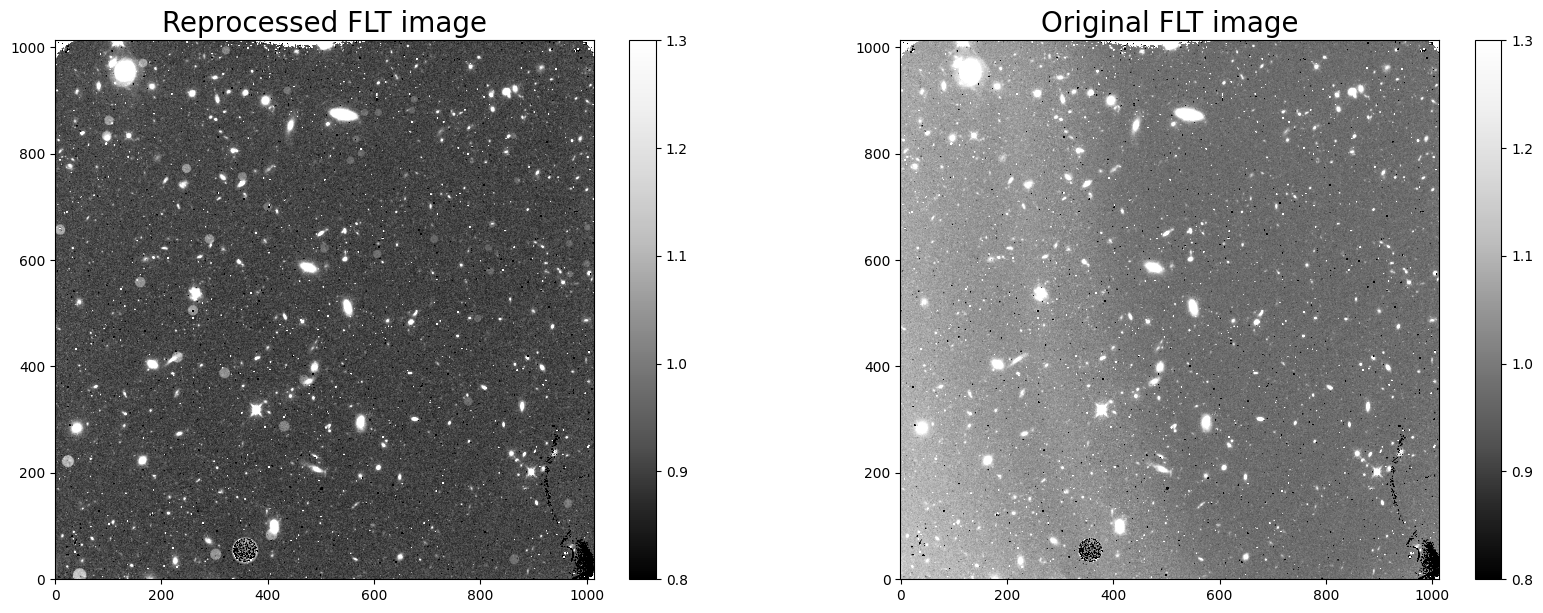

In [10]:
image_new = fits.getdata(reprocessed_flt)
image_old = fits.getdata(original_flt)

fig = plt.figure(figsize=(20, 7))
fig
rows = 1
columns = 2

# add the total exptime in the title 
ax1 = fig.add_subplot(rows, columns, 1)
ax1.set_title("Reprocessed FLT image", fontsize=20)
im1 = plt.imshow(image_new, vmin=0.8, vmax=1.3, origin='lower', cmap='Greys_r')
ax1.tick_params(axis='both', labelsize=10)
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.ax.tick_params(labelsize=10)

ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title("Original FLT image", fontsize=20)
im2 = plt.imshow(image_old, vmin=0.8, vmax=1.3, origin='lower', cmap='Greys_r')
ax2.tick_params(axis='both', labelsize=10)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.ax.tick_params(labelsize=10)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

This new image was produced by `calwf3` after masking the first 5 reads (not including the zero read) in the RAW file, reducing the effective exposure time from 1403 to 1000 seconds. While the total exposure is reduced from 1403 seconds to 1000 seconds (thus decreasing the overall S/N of the image), the background in the reprocessed image is now uniform over the entire field of view. We can see that the new FLT image is free of the Earth limb scattered light visible in the old FLT image. 

Finally, note that the reprocessed FLT product now includes a larger sky background in science pixels corresponding to IR "blobs", regions of reduced sensitivity due particulate matter on the channel selection mechanism (CSM)  mirror ([section 7.5 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-5-blobs)). 

The method for correcting WFC3/IR images described in the notebook [Correcting for Scattered Light in WFC3/IR Exposures: Manually Subtracting Bad Reads (O'Connor 2023)](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/ir_scattered_light_manual_corrections) provides FLT products without blobs, but that do include cosmic rays.

We update the FLT header keywords "EXPTIME" (in the primary header) and "SAMPTIME" (in the science header) to reflect the new total exposure time.

In [11]:
with fits.open(reprocessed_flt, mode='update') as image_new, fits.open(original_ima) as ima_orig:
        
    hdr = ima_orig[0].header
    NSAMP = hdr['NSAMP']
    hdr1 = ima_orig[1].header
    integ_time = np.zeros(shape=(NSAMP))
    for i in range(1, NSAMP+1):
        integ_time[i-1] = ima_orig[('TIME', i)].header['PIXVALUE']

    integ_time = integ_time[::-1]

    dt = np.diff(integ_time)

    final_time = integ_time[-1]

    if (len(reads) > 0):
        for read in reads:
            index = len(integ_time)-read-1 # because the reads are stored in reverse order
            final_time -= dt[index]

    print(f'The final exposure time after reprocessing is {final_time}.')
    image_new[0].header['EXPTIME'] = final_time

The final exposure time after reprocessing is 1000.0032699999998.


## 6. Drizzling Nominal and Reprocessed FLT Products <a id="drizzle"></a>

In our example we use an exposure (`icqtbbbxq`) from image association `ICQTBB020` acquired in visit BB of program [14037](https://www.stsci.edu/hst/observing/program-information). This visit consists of two orbits of two exposures each, and we now download the three other FLTs in the visit (`icqtbbc0q_flt.fits`, `icqtbbbrq_flt.fits`, `icqtbbbtq_flt.fits`) and the pipeline drizzled DRZ product. 

To produce a clean DRZ image (without blob residuals), we can drizzle the four FLTs together (from the nominal exposures and the reprocessed exposure), replacing pixels flagged as blobs with those from the dithered (nominal) image.


In [12]:
data_list = Observations.query_criteria(obs_id=OBS_ID)

Observations.download_products(data_list['obsid'], 
                               project='CALWF3',
                               mrp_only=False, 
                               productSubGroupDescription=['FLT', 'DRZ'])

 [Done]


 [Done]


 [Done]


INFO: Found cached file ./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits with expected size 16583040. [astroquery.query]

 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icqtbb020/icqtbb020_drz.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbrq/icqtbbbrq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbtq/icqtbbbtq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbc0q/icqtbbc0q_flt.fits,COMPLETE,None,None


In [13]:
nominal_file_ids = ["icqtbbc0q", "icqtbbbrq", "icqtbbbtq"]
# nominal_file_ids = ["icxt27hoq"]
nominal_list = []
for nominal_file_id in nominal_file_ids:
    shutil.copy(f'mastDownload/HST/{nominal_file_id}/{nominal_file_id}_flt.fits', f'{nominal_file_id}_flt.fits')
    nominal_list.append(f'{nominal_file_id}_flt.fits')
print(nominal_list)

['icqtbbc0q_flt.fits', 'icqtbbbrq_flt.fits', 'icqtbbbtq_flt.fits']


Next, we update the image World Coordinate System of the reprocessed image in preparation for drizzling.

In [14]:
updatewcs.updatewcs(reprocessed_flt, use_db=True)

AstrometryDB service available...


- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W


Updating astrometry for icqtbbbxq


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/icqtbbbxq


AstrometryDB service call succeeded


Retrieving astrometrically-updated WCS "OPUS" for observation "icqtbbbxq"


Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icqtbbbxq"


Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icqtbbbxq"


Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icqtbbbxq"


Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icqtbbbxq"


Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icqtbbbxq"


Updating icqtbbbxq with:


	Headerlet with WCSNAME=OPUS


	Headerlet with WCSNAME=IDC_w3m18525i


	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


	Headerlet with WCSNAME=IDC_w3m18525i-HSC30


Initializing new WCSCORR table for  icqtbbbxq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.



Replacing primary WCS with


	Headerlet with WCSNAME=IDC_w3m18525i-HSC30


['icqtbbbxq_flt.fits']

Finally, we combine the four FLT images with AstroDrizzle while exluding pixels flagged as blobs and replacing those pixels with those from dithered frames.

In [15]:
astrodrizzle.AstroDrizzle('icqtbb*flt.fits', output='f140w', 
                          mdriztab=True, preserve=False, 
                          build=False, context=False, 
                          skymethod='match', driz_separate=False, 
                          median=False, blot=False, 
                          driz_cr=False, final_bits='16',
                          clean=True)
# astrodrizzle.AstroDrizzle('icxt27*flt.fits', output='f105w', preserve=False, build=False, context=False, skymethod='match', driz_separate=False, median=False, blot=False, driz_cr=False, final_bits='16')

Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.7.1.1 started at: 19:02:28.292 (04/12/2024)


==== Processing Step  Initialization  started at  19:02:28.294 (04/12/2024)


Reading in MDRIZTAB parameters for 4 files


- MDRIZTAB: AstroDrizzle parameters read from row 3.


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 342.32386934251866 -44.54564257214722 


CRPIX : 555.5 493.5 


CD1_1 CD1_2  : -4.898034677108542e-06 -3.528668216092657e-05 


CD2_1 CD2_2  : -3.528668216092657e-05 4.898034677108542e-06 


NAXIS : 1111  987


********************************************************************************


*


*  Estimated memory usage:  up to 20 Mb.


*  Output image size:       1111 X 987 pixels. 


*  Output image file:       ~ 12 Mb. 


*  Cores available:         1


*


********************************************************************************


==== Processing Step Initialization finished at 19:02:29.01 (04/12/2024)


==== Processing Step  Static Mask  started at  19:02:29.018 (04/12/2024)


==== Processing Step Static Mask finished at 19:02:29.079 (04/12/2024)


==== Processing Step  Subtract Sky  started at  19:02:29.080 (04/12/2024)


***** skymatch started on 2024-12-04 19:02:29.131760


      Version 1.0.10


'skymatch' task will apply computed sky differences to input image file(s).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


'MDRIZSKY' header keyword will represent sky value *computed* from data.


-----  User specified keywords:  -----


       Sky Value Keyword:  'MDRIZSKY'


       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----


   **  Input image: 'icqtbbbrq_flt.fits'


       EXT: 'SCI',1;	MASK: icqtbbbrq_skymatch_mask_sci1.fits[0]


   **  Input image: 'icqtbbbtq_flt.fits'


       EXT: 'SCI',1;	MASK: icqtbbbtq_skymatch_mask_sci1.fits[0]


   **  Input image: 'icqtbbbxq_flt.fits'


       EXT: 'SCI',1;	MASK: icqtbbbxq_skymatch_mask_sci1.fits[0]


   **  Input image: 'icqtbbc0q_flt.fits'


       EXT: 'SCI',1;	MASK: icqtbbc0q_skymatch_mask_sci1.fits[0]


-----  Sky statistics parameters:  -----


       statistics function: 'mode'


       lower = -100.0


       upper = None


       nclip = 5


       lsigma = 4.0


       usigma = 4.0


       binwidth = 0.10000000149011612


-----  Data->Brightness conversion parameters for input files:  -----


   *   Image: icqtbbbrq_flt.fits


       EXT = 'SCI',1


             Data units type: COUNT-RATE


             Conversion factor (data->brightness):  60.797431635711504


   *   Image: icqtbbbtq_flt.fits


       EXT = 'SCI',1


             Data units type: COUNT-RATE


             Conversion factor (data->brightness):  60.797431635711504


   *   Image: icqtbbbxq_flt.fits


       EXT = 'SCI',1


             Data units type: COUNT-RATE


             Conversion factor (data->brightness):  60.797431635711504


   *   Image: icqtbbc0q_flt.fits


       EXT = 'SCI',1


             Data units type: COUNT-RATE


             Conversion factor (data->brightness):  60.797431635711504


-----  Computing differences in sky values in overlapping regions:  -----


   *   Image 'icqtbbbrq_flt.fits['SCI',1]' SKY = 1.87266 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0308016


   *   Image 'icqtbbbtq_flt.fits['SCI',1]' SKY = 0 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


   *   Image 'icqtbbbxq_flt.fits['SCI',1]' SKY = None (undetermined)


       Sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = None   NEW MDRIZSKY = OLD MDRIZSKY = 0


   *   Image 'icqtbbc0q_flt.fits['SCI',1]' SKY = 0.354745 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00583486


***** skymatch ended on 2024-12-04 19:02:32.107700


TOTAL RUN TIME: 0:00:02.975940


==== Processing Step Subtract Sky finished at 19:02:32.15 (04/12/2024)


==== Processing Step  Separate Drizzle  started at  19:02:32.15 (04/12/2024)


==== Processing Step Separate Drizzle finished at 19:02:32.161 (04/12/2024)


==== Processing Step  Create Median  started at  19:02:32.162 (04/12/2024)


==== Processing Step  Blot  started at  19:02:32.163 (04/12/2024)


==== Processing Step Blot finished at 19:02:32.16 (04/12/2024)


==== Processing Step  Driz_CR  started at  19:02:32.165 (04/12/2024)


==== Processing Step  Final Drizzle  started at  19:02:32.167 (04/12/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 342.32386934251866 -44.54564257214722 


CRPIX : 555.5 493.5 


CD1_1 CD1_2  : -4.898034677108542e-06 -3.528668216092657e-05 


CD2_1 CD2_2  : -3.528668216092657e-05 4.898034677108542e-06 


NAXIS : 1111  987


-Generating simple FITS output: f140w_drz_sci.fits


Writing out image to disk: f140w_drz_sci.fits


Writing out image to disk: f140w_drz_wht.fits


==== Processing Step Final Drizzle finished at 19:02:33.592 (04/12/2024)


AstroDrizzle Version 3.7.1.1 is finished processing at 19:02:33.594 (04/12/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.7227 sec.


            Static Mask          0.0602 sec.


           Subtract Sky          3.0785 sec.


       Separate Drizzle          0.0016 sec.


          Create Median          0.0000 sec.


                   Blot          0.0015 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          1.4254 sec.


   ====================          ====================


                  Total          5.2898 sec.


Trailer file written to:  astrodrizzle.log


Comparing the new DRZ image made with the reprocessed FLT product against the original pipeline DRZ image, we see that the new DRZ image no longer includes scattered light but has a slightly lower S/N due the reduced total exposure time from 1403 to 1000 seconds. 

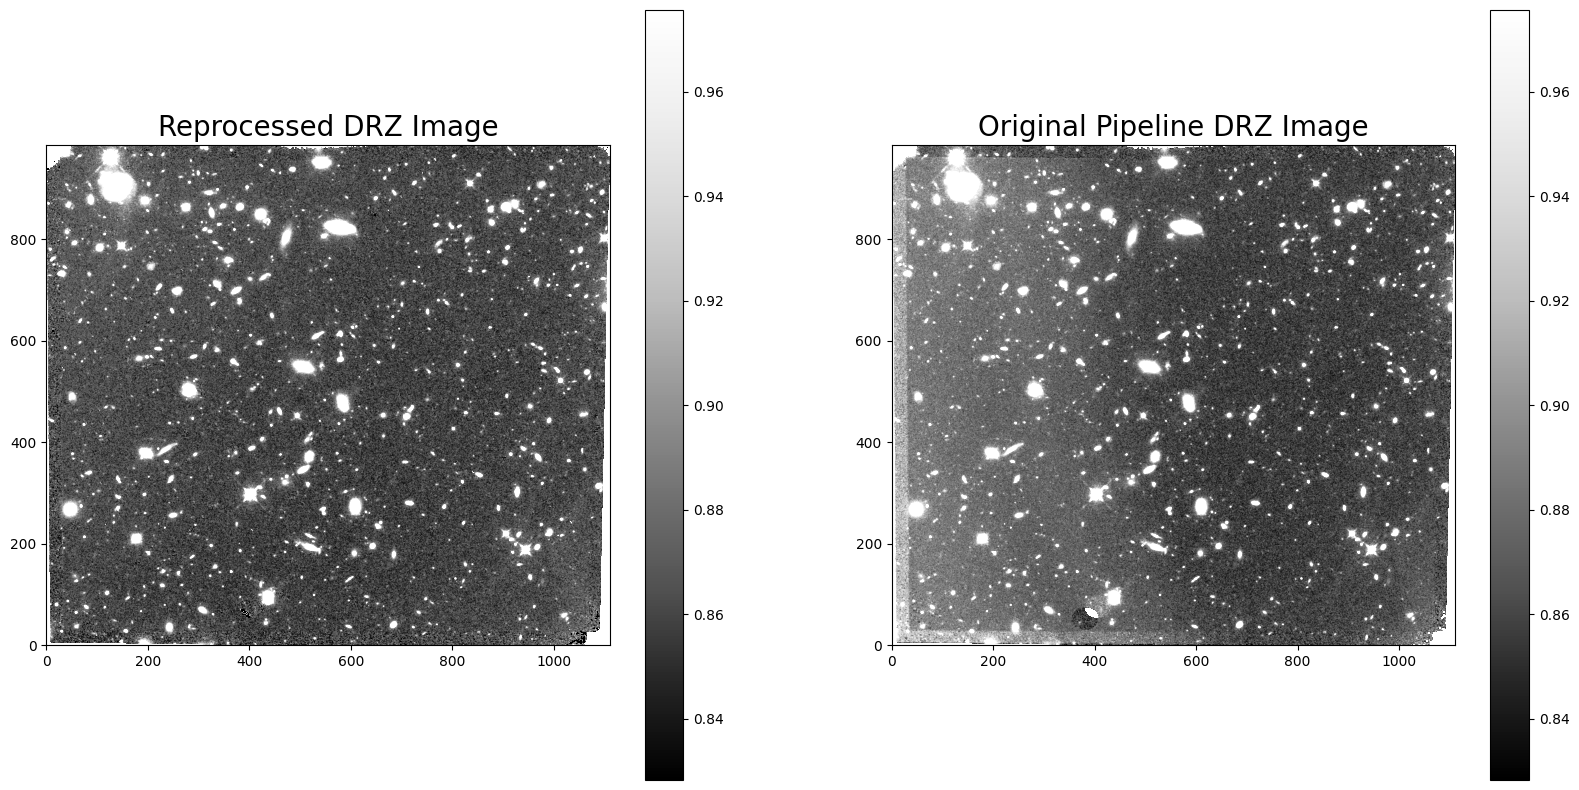

In [16]:
with fits.open("f140w_drz_sci.fits") as DRZ_image, fits.open('mastDownload/HST/icqtbb020/icqtbb020_drz.fits') as Orig_DRZ:

    fig = plt.figure(figsize=(20, 10))
    rows = 1
    columns = 2

    ax1 = fig.add_subplot(rows, columns, 1)
    ax1.set_title("Reprocessed DRZ Image", fontsize=20)
    vmin, vmax = zscale(Orig_DRZ[1].data)
    im1 = plt.imshow(DRZ_image[0].data, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys_r')
    _ = plt.colorbar()

    ax2 = fig.add_subplot(rows, columns, 2)
    ax2.set_title("Original Pipeline DRZ Image", fontsize=20)
    im2 = plt.imshow(Orig_DRZ[1].data, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys_r')
    _ = plt.colorbar()

## 7. Conclusions <a id="conclusions"></a>

**Congratulations, you have completed the notebook.**

You should now be familiar with how to reprocess an observation affected by Earth limb scattered light by removing the first few reads and rerunning `calwf3`.

Thank you for following along! 

## Additional Resources <a id="add"></a>


Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
    - [WFC3/UVIS CTE Website](https://www.stsci.edu/hst/instrumentation/wfc3/performance/cte)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)

## About this Notebook <a id="about"></a>


**Author:** Anne O'Connor, Jennifer Mack, Annalisa Calamida, Harish Khandrika -- WFC3 Instrument

**Updated On:** 2023-12-26

## Citations <a id="cite"></a>

If you use the following tools for published research, please cite the
authors. Follow these links for more information about citing the tools:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `wfc3tools`](https://wfc3tools.readthedocs.io/en/latest/)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)


If you use this notebook, or information from the WFC3 Data Handbook, Instrument Handbook,
or WFC3 ISRs for published research, please cite them:

* [Citing the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb#:~:text=Citation,%2C%20(Baltimore%3A%20STScI).)
* [Citing the WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb#:~:text=Citation,14.0%E2%80%9D%20(Baltimore%3A%20STScI))
* [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)
* Citing this notebook:
    Please cite the primary author and year, and hyperlink the notebook or HST/WFC3 Notebooks
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 